In [25]:
# General (scientific) computing
import os
import time
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Ellipse
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# Astronomical computing
import fitsio
from astropy.visualization import simple_norm, AsinhStretch
#import astroalign as aa
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

# Your Image Calibration and Photometry Code
from complete_process import average_bias, average_dark, average_flat, science_exposure
# Note that you do not need to have magnitude errors implemented. That is for lab 1.5! Returning 0 for all
# magnitude errors is fine for now.
from TA_photometry import create_phot_cat, aper_flux, aper_mag

In [2]:
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
coadd_R_filename = './data/Coadded_Data/coadded_R.fit'
coadd_Ha_filename = './data/Coadded_Data/coadded_Ha.fit'

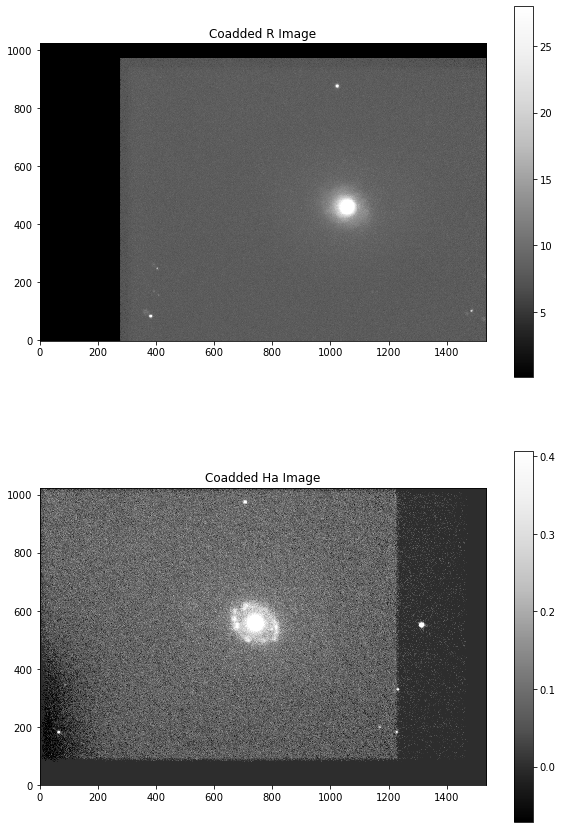

In [4]:
fig, axs = plt.subplots(2, figsize=(10,15))
imR, headerR = fitsio.read(coadd_R_filename, header=True)
imHa, headerHa = fitsio.read(coadd_Ha_filename, header=True)
im1 = axs[0].imshow(imR, vmin=np.median(imR)-2*np.std(imR), vmax=np.median(imR)+5*np.std(imR))
im2 = axs[1].imshow(imHa, vmin=np.median(imHa)-2*np.std(imHa), vmax=np.median(imHa)+5*np.std(imHa))
axs[0].set_title("Coadded R Image")
axs[1].set_title("Coadded Ha Image")
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])
plt.show()

In [13]:
datadir = './data/'
caldir = datadir + 'Calibration/'

# These calibration files are for the first day of observing
early_biasfiles = glob.glob(caldir + 'Biases/2022_04_28/*.fit')
early_darkfiles = glob.glob(caldir + 'Darks/2022_04_06/*.fit')

# These calibration files are for the other days of observing
late_biasfiles = glob.glob(caldir + 'Biases/2022_05_11/*.fit')
late_darkfiles = glob.glob(caldir + 'Darks/2022_05_11/*.fit')


In [18]:
early_masterbias = average_bias(early_biasfiles)
late_masterbias = average_bias(late_biasfiles)
print(np.std(early_masterbias), np.std(late_masterbias))

3.4934947763773803 3.1409296805752427


In [19]:
early_masterdark = average_dark(early_darkfiles, early_masterbias)
late_masterdark = average_dark(late_darkfiles, late_masterbias)
print(np.mean(early_masterdark), np.mean(late_masterdark))

0.07143249638710437 0.07738150368580866


In [20]:
avg_dark_current = np.mean([np.std(early_masterbias), np.std(late_masterbias)])
read_noise = np.mean([np.mean(early_masterdark), np.mean(late_masterdark)])
print(avg_dark_current, read_noise)

3.3172122284763113 0.07440700003645652


In [70]:
Rx, Ry = 1054, 458
ref_Rx, ref_Ry = 1023, 877
Hax, Hay = 740, 556
ref_Hax, ref_Hay = 706, 972
ref_true_mag = 9.95

In [87]:
imR, headerR = fitsio.read(coadd_R_filename, header=True)
flux, fluxerr, _ = aper_flux(imR, Rx, Ry, exptime=1, errFlag=True,
          avg_dark_current=avg_dark_current, read_noise=read_noise)
mag, magerr = aper_mag(flux, fluxerr)
ref_flux, ref_fluxerr, _ = aper_flux(imR, ref_Rx, ref_Ry, exptime=1, errFlag=True, source_radius=50,
          avg_dark_current=avg_dark_current, read_noise=read_noise)
ref_mag, ref_magerr = aper_mag(ref_flux, ref_fluxerr)
corrected_mag_R = ref_true_mag - ref_mag + mag

In [88]:
imHa, headerHa = fitsio.read(coadd_Ha_filename, header=True)
flux, fluxerr, _ = aper_flux(imHa, Hax, Hay, exptime=1, errFlag=True,
          avg_dark_current=avg_dark_current, read_noise=read_noise)
mag, magerr = aper_mag(flux, fluxerr)
ref_flux, ref_fluxerr, _ = aper_flux(imHa, ref_Hax, ref_Hay, exptime=1, errFlag=True, source_radius=50,
          avg_dark_current=avg_dark_current, read_noise=read_noise)
ref_mag, ref_magerr = aper_mag(ref_flux, ref_fluxerr)
corrected_mag_Ha = ref_true_mag - ref_mag + mag

In [92]:
print(corrected_mag_R, corrected_mag_Ha)
print("Magnitude difference is", corrected_mag_Ha-corrected_mag_R)

8.165538583906471 8.53970311987494
Magnitude difference is 0.3741645359684682


In [94]:
# Now we will calculate the difference in Flux
dF = 10 ** (2.5 * corrected_mag_Ha) - 10 ** (2.5 * corrected_mag_R)
print("Flux difference is", dF)

Flux difference is 1.9755722397218832e+21


In [ ]:
# Now convert flux to different units
# Flux is in counts / second right now, we need to convert to W/m^2

In [84]:
mag, magerr

(-6.3450195807995415, 0.0745074772906707)

In [85]:
ref_mag, ref_magerr

(-4.93472270067448, 1.0919175401698158)

In [86]:
corrected_mag = ref_true_mag - ref_mag + mag
corrected_mag

8.53970311987494